<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part4/P4_Ch03_CH03_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [15]:
def create_seq_model():
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape = (28,28))) # mlp에 들어오려면 일자로 쭉 펴져야함 -> flatten으로 벡터화
  model.add(keras.layers.Dense(128, activation = 'relu')) #layer 1
  model.add(keras.layers.Dropout(0.2))  #overfitting방지
  model.add(keras.layers.Dense(10, activation = 'softmax')) #layer 2면서 output layer
  return model

In [16]:
seq_model = create_seq_model()

In [17]:
mnist = keras.datasets.fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Sneaker', 'Shirt', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [18]:
#image를 0-1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32)/ 255.
test_images = test_images.astype(np.float32)/255.

#one-hot encoding
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size = 100000).batch(64)
    # train을 shuffle하지 않으면 학습이 끝날때마다 같은 순서의 데이터들이 들어감
    # from_tensor_slices : 하나씩 가져오는거
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(64)

# Training /Validation

## Keras API사용

In [20]:
learning_rate = 0.001
seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [22]:
history = seq_model.fit(train_dataset, epochs= 10, validation_data = test_dataset)

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2806 - accuracy: 0.8965 - val_loss: 0.3366 - val_accuracy: 0.8776
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2725 - accuracy: 0.8984 - val_loss: 0.3292 - val_accuracy: 0.8830
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2667 - accuracy: 0.9004 - val_loss: 0.3221 - val_accuracy: 0.8877
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2650 - accuracy: 0.9013 - val_loss: 0.3278 - val_accuracy: 0.8852
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2598 - accuracy: 0.9023 - val_loss: 0.3282 - val_accuracy: 0.8863
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2549 - accuracy: 0.9047 - val_loss: 0.3209 - val_accuracy: 0.8879
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2506 - accuracy: 0.9056 - val_loss: 0.3287 - val_accuracy: 0.8860
Epoch 

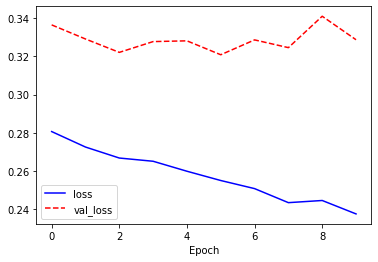

In [23]:
# Plot losses
plt.plot(history.history['loss'], 'b-', label ='loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

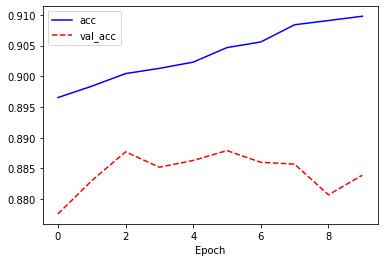

In [24]:
# Plot Accuracy
plt.plot(history.history['accuracy'], 'b-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r--', label = 'val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## GradientTape사용

In [25]:
# loss function
loss_object = keras.losses.CategoricalCrossentropy()



In [26]:
#optimizer
learning_rate =0.001
optimizer = keras.optimizers.Adam(learning_rate =learning_rate)


In [27]:
# loss, accuracy 계산
train_loss = keras.metrics.Mean(name = 'train_loss') #64개 배치들이 한 epoch를 돌때마다 평균내는것.
train_accuracy = keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = keras.metrics.Mean(name = 'test_loss')
test_accuracy = keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [36]:
@tf.function   #decorater -> graph모드 : 속도 빠르게 해줌
def train_step(model, images, labels):
  with tf.GradientTape() as tape:
    # GradientTape :backpropagation 해줌
    predictions = model(images, training = True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables) # 뭐를 뭐로 나눌지 지정해야함 : loss를 trainable variables로 미분 -> model.trainable_variables에 모든 weight, bias들어있음
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # update

  train_loss(loss)
  train_accuracy(labels, predictions)

In [37]:
@tf.function
def test_step(model, images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [39]:
 #functional API
def create_func_model(): 
  inputs = keras.Input(shape=(28,28))
  flatten = keras.layers.Flatten()(inputs)  # sequential과 다르게 input이 뭔지 계속 알려줘야한다
  dense = keras.layers.Dense(128, activation = 'relu')(flatten)
  drop = keras.layers.Dropout(0.2)(dense)
  outputs = keras.layers.Dense(10, activation = 'softmax')(drop)
  model = keras.Model(inputs = inputs, outputs = outputs)
  return model

In [40]:
func_model = create_func_model()

In [41]:
func_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 실제 훈련

EPOCHS = 10
for epoch in range(EPOCHS):
  # reset the metrics at the start on the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()

  for images, labels in train_dataset:
    train_step(func_model, images, labels)
  for test_images, test_labels in test_dataset:
    test_step(func_model, test_images, test_labels)

  print(
      f'Epoch: {epoch +1},'
      f'Loss: {train_loss.result()},'
      f'Accuracy:{train_accuracy.result()*100},'
      f'Test Loss: {test_loss.result()},'
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

Epoch: 1,Loss: 0.31920379400253296,Accuracy:88.27333068847656,Test Loss: 0.3783666491508484,Test Accuracy: 86.34166717529297
Epoch: 2,Loss: 0.30873656272888184,Accuracy:88.72833251953125,Test Loss: 0.3737354874610901,Test Accuracy: 86.54857635498047
Epoch: 3,Loss: 0.2978671193122864,Accuracy:88.94332885742188,Test Loss: 0.36938539147377014,Test Accuracy: 86.70750427246094
Epoch: 4,Loss: 0.2909674346446991,Accuracy:89.18333435058594,Test Loss: 0.36673468351364136,Test Accuracy: 86.82555389404297
Epoch: 5,Loss: 0.2826237380504608,Accuracy:89.5683364868164,Test Loss: 0.3632776439189911,Test Accuracy: 86.92900085449219
Epoch: 6,Loss: 0.2771906554698944,Accuracy:89.70999908447266,Test Loss: 0.36102160811424255,Test Accuracy: 87.05181884765625
Epoch: 7,Loss: 0.2723610997200012,Accuracy:89.87332916259766,Test Loss: 0.35789015889167786,Test Accuracy: 87.15833282470703
Epoch: 8,Loss: 0.2673262059688568,Accuracy:90.0633316040039,Test Loss: 0.35624998807907104,Test Accuracy: 87.22846221923828
Epo